# Clustering and Annotation of cell segmentations, trial 2

Segmentation was performed with Baysor
*Remember: The Baysor preview is vertically mirrored from Visualizer*

this is a copy of 'clustering_EDA.ipynb', but using the results from the second clustering trial:
m = 50
s = 50
std.dev = 25%

"segment_m50_std25_s50_lessCPU"

also, testing all variations on min molecule (m) trials: 50, 100, 150, 200

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np
import anndata as ad
import pickle as pk

## Importing some stuff

In [2]:
# Orginal MERSCOPE transcripts
genes = pd.read_csv("../data/detected_transcripts_wPixel.csv")

In [3]:
genes.head()

Unnamed: 0  barcode_id    global_x   global_y  global_z          x  \
0         161           0  205.033570  3673.6423       0.0  1898.4589   
1        1202           0  127.298164  3624.1118       2.0  1178.6866   
2        3738           0  102.508125  3625.4592       6.0   949.1493   
3       11489           3  146.474410  3673.4827       4.0  1356.2445   
4       13130           4  138.442900  3771.7260       0.0  1281.8787   

            y  fov   gene    transcript_id  global_xpixel  global_ypixel  
0   679.20660    0    CD4  ENST00000011653    1898.457695   34015.183434  
1   220.59117    0    CD4  ENST00000011653    1178.685905   33556.568004  
2   233.06530    0    CD4  ENST00000011653     949.148662   33569.043922  
3   677.72650    0   CD22  ENST00000085219    1356.243618   34013.705657  
4  1587.38840    0  TBX21  ENST00000177694    1281.877835   34923.365226

### subsample data for segmentation testing

this is a little out of place, but didn't want to start new node in 01-preprocessing

In [30]:

xmin = 72000
xmax = 77000
ymin = 41000
ymax = 46000

In [31]:
small = genes[(genes['global_xpixel'] > xmin) & (genes['global_xpixel'] < xmax) & (genes['global_ypixel'] > ymin) & (genes['global_ypixel'] < ymax)]
small.shape

(394150, 12)

In [32]:
small.to_csv('../data/small_detected_transcripts.csv')

In [4]:
# Baysor predictions
dat = pd.read_csv("../02-Baysor/segment_m150_std25_s50/segmentation.csv")
dat.describe()

Unnamed: 0    barcode_id      global_x      global_y             z  \
count  4.411474e+07  4.411474e+07  4.411474e+07  4.411474e+07  4.411474e+07   
mean   7.907382e+05  1.762973e+02  6.119196e+03  4.324429e+03  3.099243e+00   
std    5.160272e+05  1.134948e+02  2.220960e+03  1.737806e+03  1.983492e+00   
min    0.000000e+00  0.000000e+00  1.107802e+01  2.008378e+01  0.000000e+00   
25%    3.461290e+05  7.600000e+01  4.493081e+03  2.970613e+03  1.000000e+00   
50%    7.845130e+05  1.850000e+02  6.056730e+03  4.351604e+03  3.000000e+00   
75%    1.144620e+06  2.590000e+02  7.815162e+03  5.788067e+03  5.000000e+00   
max    1.979085e+06  3.970000e+02  1.161126e+04  7.610976e+03  6.000000e+00   

         x_reserved    y_reserved           fov             x             y  \
count  4.411474e+07  4.411474e+07  4.411474e+07  4.411474e+07  4.411474e+07   
mean   1.018370e+03  1.045499e+03  7.280777e+02  5.665918e+04  4.004098e+04   
std    5.299651e+02  5.247604e+02  3.208998e+02  2.056443e+04  1.609079e+04   
min    9.800000e+01  9.800000e+01  0.000000e+00  1.025742e+02  1.859608e+02   
25%    5.632784e+02  6.015048e+02  4.720000e+02  4.160258e+04  2.750566e+04   
50%    1.014731e+03  1.059415e+03  7.390000e+02  5.608080e+04  4.029260e+04   
75%    1.475307e+03  1.494515e+03  1.009000e+03  7.236256e+04  5.359318e+04   
max    1.950000e+03  1.950000e+03  1.293000e+03  1.075116e+05  7.047195e+04   

        molecule_id    confidence       cluster          cell  \
count  4.411474e+07  4.411474e+07  4.411474e+07  4.411474e+07   
mean   2.205737e+07  7.435497e-01  2.201173e+00  1.445418e+04   
std    1.273483e+07  3.897613e-01  8.084483e-01  1.277846e+04   
min    1.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   
25%    1.102869e+07  5.909000e-01  2.000000e+00  0.000000e+00   
50%    2.205737e+07  9.807700e-01  2.000000e+00  1.300900e+04   
75%    3.308606e+07  9.932100e-01  2.000000e+00  2.592500e+04   
max    4.411474e+07  9.954100e-01  4.000000e+00  4.210900e+04   

       assignment_confidence  
count           4.411474e+07  
mean            9.366734e-01  
std             1.214474e-01  
min             5.000000e-02  
25%             9.500000e-01  
50%             1.000000e+00  
75%             1.000000e+00  
max             1.000000e+00

In [42]:
# shouldn't need to do this anymore...
# scale = (dat['global_y'][1] - dat['global_y'][0]) / (dat['y'][1] - dat['y'][0])
# print(dat['global_x'].min()/scale)
# print(dat['global_x'].max()/scale)
# print(dat['global_y'].min()/scale)
# print(dat['global_y'].max()/scale)

7505.985124388317
9357.960231162784
46398.076532003135
48249.87812063079


In [5]:
# preview small section of data
# small = adata.obs[(adata.obs['x'] > 55000) & (adata.obs['x'] < 57000) & (adata.obs['y'] > 55000) & (adata.obs['y'] < 57000)]
small = dat[(dat['x'] > 55000) & (dat['x'] < 57000) & (dat['y'] > 55000) & (dat['y'] < 57000)]
small.shape

(90995, 19)

In [6]:
new_id_dict = dict(zip(list(small['cell'].unique()), range(small['cell'].nunique())))
small['new_cell'] = small['cell'].apply(lambda x: new_id_dict[x])

/tmp/ipykernel_3224071/297230123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small['new_cell'] = small['cell'].apply(lambda x: new_id_dict[x])


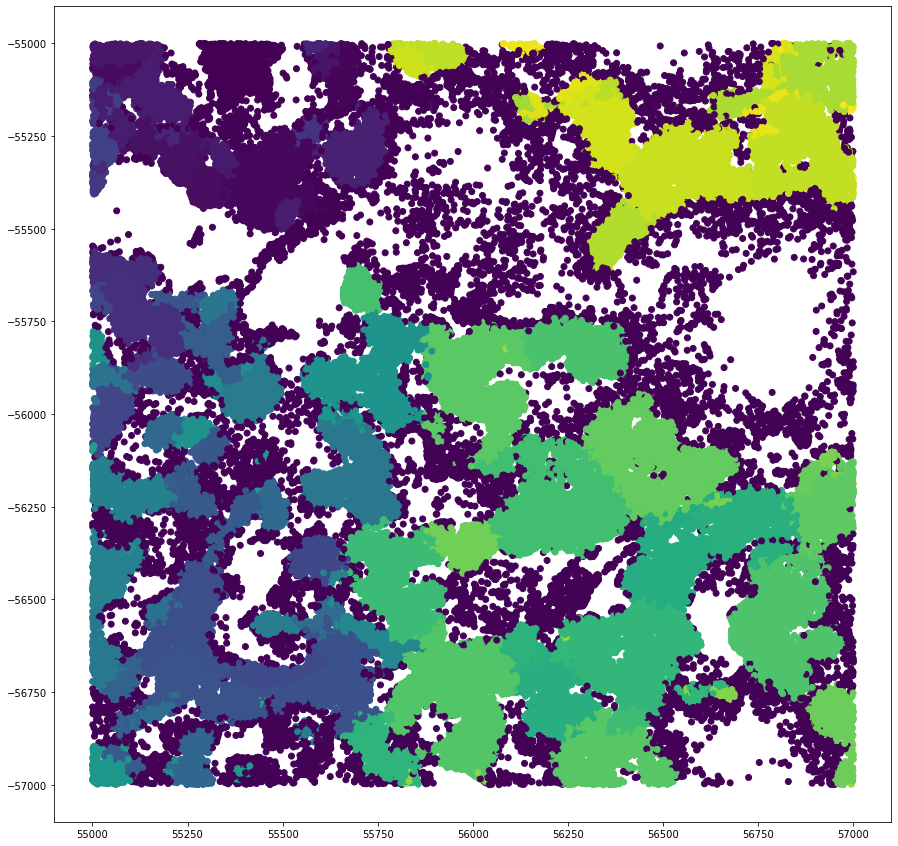

In [7]:
plt.figure(figsize=(15, 15))
plt.scatter(small['x'], -small['y'], c=small['new_cell'])
plt.show()

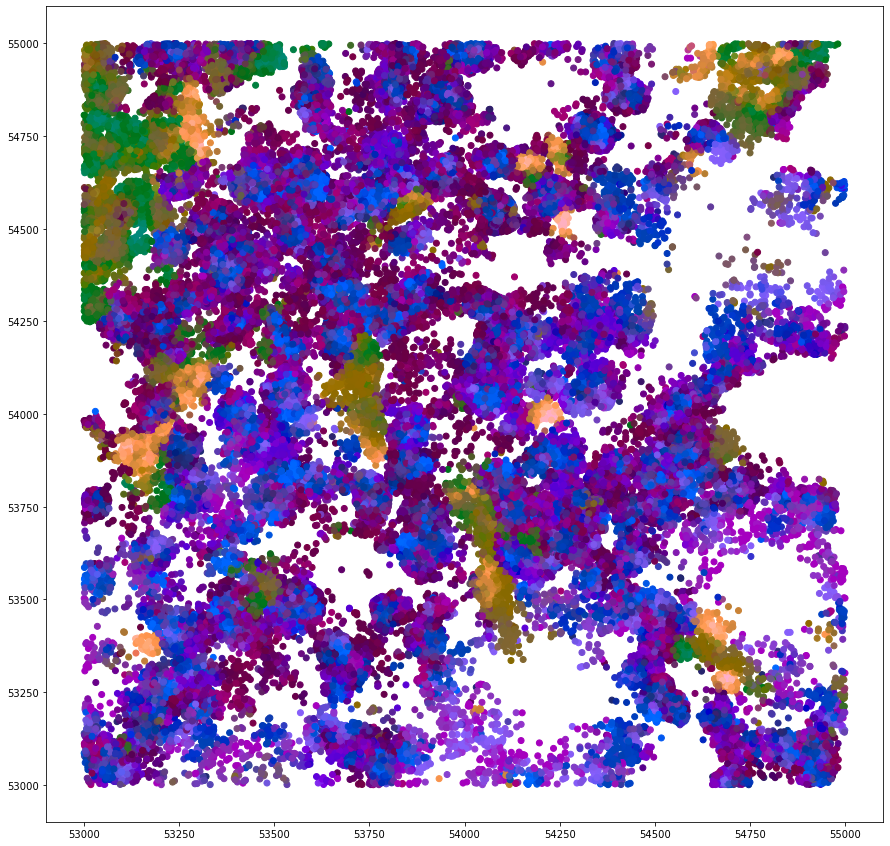

In [31]:
plt.figure(figsize=(15, 15))
plt.scatter(small['x'], small['y'], c=small['ncv_color'])
plt.show()

In [27]:
small[small['x']==small['x'].min()].head()

Unnamed: 0  barcode_id  global_x   global_y    z  x_reserved  \
16958692     1558663         344  5400.008  5462.6006  0.0   1848.0703   

          y_reserved  fov  gene    transcript_id  ...             y  \
16958692   575.63605  610  RTN3  ENST00000537981  ...  50579.600914   

          molecule_id  prior_segmentation  confidence  cluster   cell  \
16958692     16958693                   0     0.99773        3  52004   

          assignment_confidence  is_noise  ncv_color new_cell  
16958692                    1.0     False    #593FA9        9  

[1 rows x 21 columns]

/mnt/isilon/cscb/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


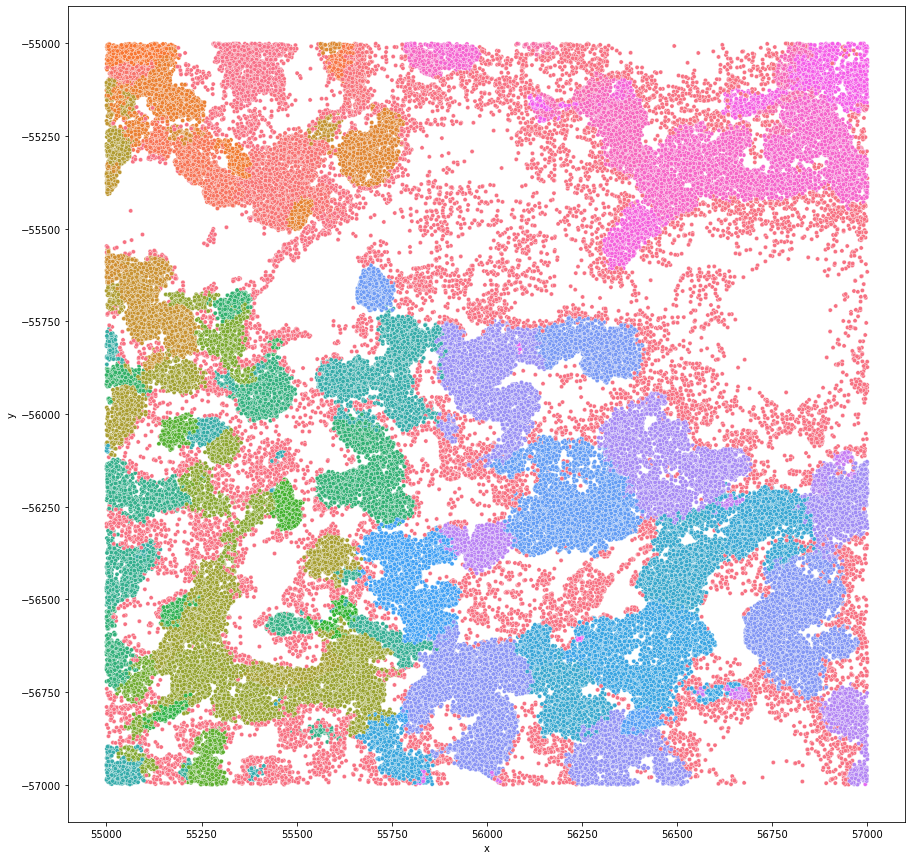

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
out = sns.scatterplot(small['x'], -small['y'], hue=small['new_cell'].astype(str), size=0.1, legend=False)
out = out.get_figure()
out.savefig("plots/small_seg_2_m200.png")
plt.show()

## Making an AnnData object

I'll need two dataframes; count matrix, and metadata
- collapse on cell ID
- count gene occurances
- average x, y coordinates
- average global coordinates
- median or mode cluster, should all be the same number

In [33]:
dat.columns

Index(['Unnamed: 0', 'barcode_id', 'global_x', 'global_y', 'z', 'x_reserved',
       'y_reserved', 'fov', 'gene', 'transcript_id', 'x', 'y', 'molecule_id',
       'prior_segmentation', 'confidence', 'cluster', 'cell',
       'assignment_confidence', 'is_noise', 'ncv_color'],
      dtype='object')

In [9]:
datTrim = dat[['cell', 'cluster' , 'gene', 'x', 'y', 'global_x', 'global_y']]
datTrim = datTrim[datTrim['cell'] != 0]
datTrim.head()

cell  cluster    gene            x             y   global_x   global_y
21413    23        2  PHOX2B  7270.605722  25765.819579  785.22595  2782.7104
21491    20        2    ENO2  6977.690643  25835.488050  753.59110  2790.2346
21534    23        2    ENO2  7272.533035  25682.321488  785.43410  2773.6926
21538    23        2    ENO2  7251.084902  25721.167757  783.11770  2777.8880
21541    23        2    ENO2  7293.167836  25742.393669  787.66266  2780.1804

In [10]:
count = datTrim.groupby(['cell', 'gene']).agg(count=('gene', 'count')).reset_index()
count = count.pivot(index='cell', columns='gene', values='count')
count.shape

(42109, 398)

In [11]:
meta = datTrim.groupby('cell').agg({
    'cluster':'first',
    'x':'mean',
    'y':'mean',
    'global_x':'mean',
    'global_y':'mean'})
meta.index = meta.index.map(str)
meta.head()

cluster            x             y     global_x     global_y
cell                                                              
1           3  8785.483794  21130.946109   948.832893  2282.143726
2           2  8957.889297  21050.091055   967.452700  2273.411374
3           3  9325.548405  20630.445925  1007.159910  2228.089670
4           3  9146.969025  20853.519281   987.873324  2252.181608
5           2  8571.973636  21527.898674   925.773780  2325.014632

In [12]:
count.fillna(0, inplace=True)
count.head()

gene  A2M  ABCC2  ABCG2  ABTB2  ACLY  ACSL1  ACTA2  ADAMTS9  ADCYAP1  ADGRB3  \
cell                                                                           
1     0.0    0.0    0.0    0.0   0.0    0.0    0.0      0.0      0.0     0.0   
2     0.0    0.0    0.0    1.0  17.0    4.0    0.0      0.0      0.0     5.0   
3     1.0    0.0    0.0    0.0  23.0    3.0    0.0      0.0      0.0     7.0   
4     0.0    0.0    0.0    1.0  23.0    5.0    0.0      0.0      0.0    10.0   
5     0.0    0.0    0.0    1.0   2.0    0.0    0.0      0.0      0.0     0.0   

gene  ...  VIM  WWTR1  ZBTB16  ZBTB20  ZFAND3  ZFHX3  ZFPM2  ZHX2  ZNF331  \
cell  ...                                                                   
1     ...  0.0    0.0     0.0     0.0     0.0    0.0    0.0   0.0     0.0   
2     ...  0.0    0.0     0.0     0.0     1.0   12.0    0.0   0.0     2.0   
3     ...  3.0    0.0     0.0     2.0     0.0   20.0    2.0   0.0     3.0   
4     ...  0.0    0.0     1.0     3.0     0.0   11.0    1.0   1.0     0.0   
5     ...  0.0    0.0     0.0     2.0     0.0    4.0    0.0   0.0     0.0   

gene  ZNF804A  
cell           
1         0.0  
2         3.0  
3         5.0  
4         8.0  
5         2.0  

[5 rows x 398 columns]

In [13]:
adata = ad.AnnData(count)

/mnt/isilon/cscb/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
adata.obs = meta

In [2]:
adata.write('baysor_seg.h5ad')
# adata = ad.read('baysor_seg.h5ad')

## Processing and Clustering

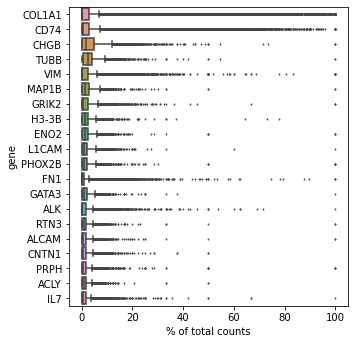

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20) # looks like there are cells that only contain one gene?

In [16]:
sc.pp.filter_cells(adata, min_genes=3)
sc.pp.filter_genes(adata, min_cells=100)
adata

AnnData object with n_obs × n_vars = 41511 × 398
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes'
    var: 'n_cells'

In [17]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [18]:
adata.obs.describe()

cluster              x             y      global_x      global_y  \
count  41511.000000   41511.000000  41511.000000  41511.000000  41511.000000   
mean       2.895714   57331.858167  40020.265929   6191.844877   4322.191649   
std        0.864035   20670.059467  16270.371032   2232.367935   1757.201262   
min        1.000000    6954.604556    650.846222    751.097801     70.291440   
25%        2.000000   41843.392281  27097.116304   4519.089428   2926.490544   
50%        3.000000   56579.290685  40392.339396   6110.567534   4362.375611   
75%        4.000000   73180.362299  53634.031931   7903.484483   5792.479373   
max        4.000000  106679.605496  70447.869426  11521.405200   7608.375053   

            n_genes  n_genes_by_counts  total_counts  
count  41511.000000       41511.000000  41511.000000  
mean     114.683963         114.683963    782.091492  
std       74.308386          74.308386    931.606079  
min        3.000000           3.000000      3.000000  
25%       48.000000          48.000000    125.000000  
50%      106.000000         106.000000    382.000000  
75%      180.000000         180.000000   1140.000000  
max      317.000000         317.000000   7977.000000

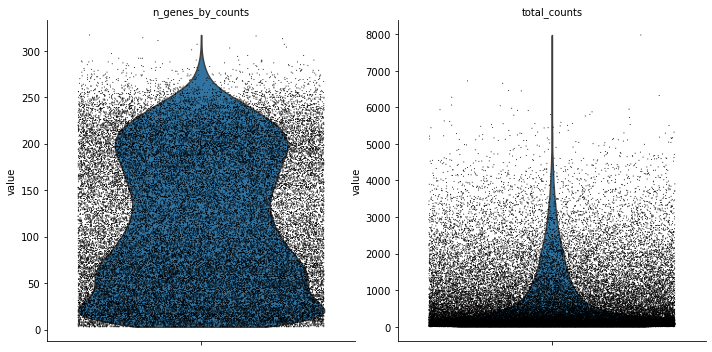

In [19]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

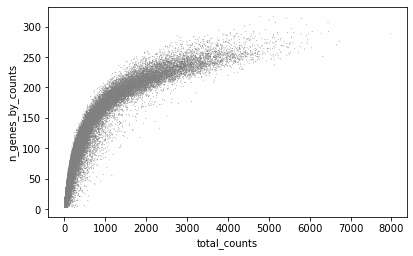

In [20]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [100]:
# adata = adata[adata.obs.total_counts < 2000, :]

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [22]:
adata.raw = adata

In [23]:
sc.pp.scale(adata)

In [24]:
sc.tl.pca(adata, svd_solver='arpack')

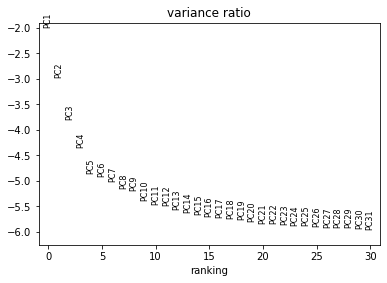

In [106]:
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

In [26]:
sc.tl.umap(adata)

In [27]:
sc.tl.leiden(adata)

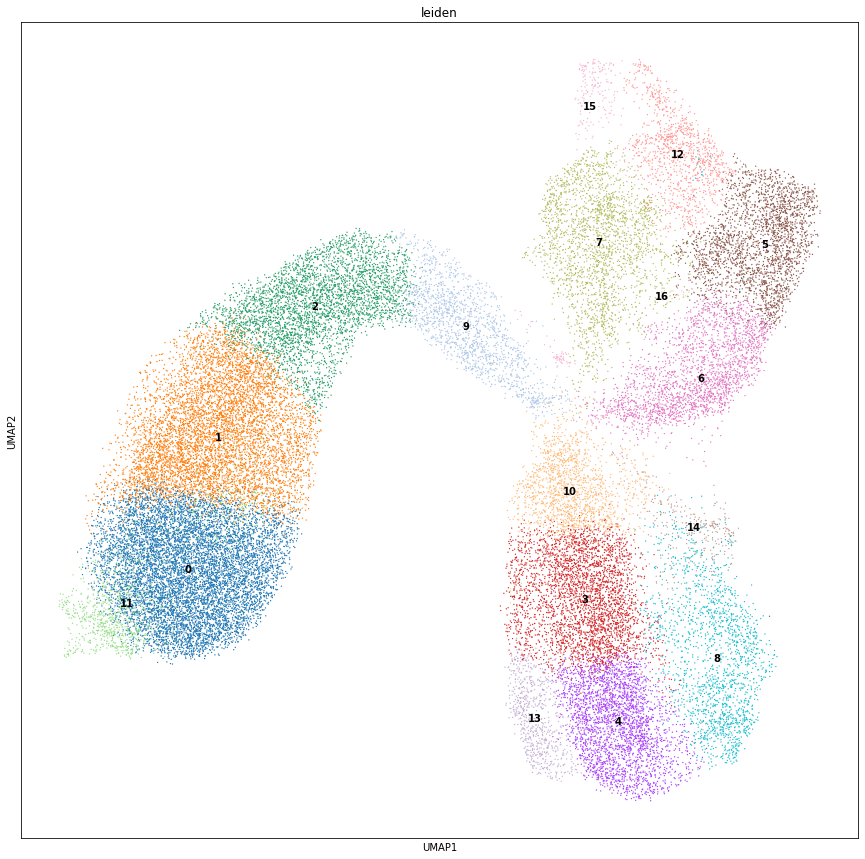

In [28]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata, color='leiden', ax=ax, size=7, legend_loc='on data')
plt.show()

In [123]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

/mnt/isilon/cscb/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/mnt/isilon/cscb/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/mnt/isilon/cscb/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-

In [19]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0:20,].to_csv('top_markers.csv')

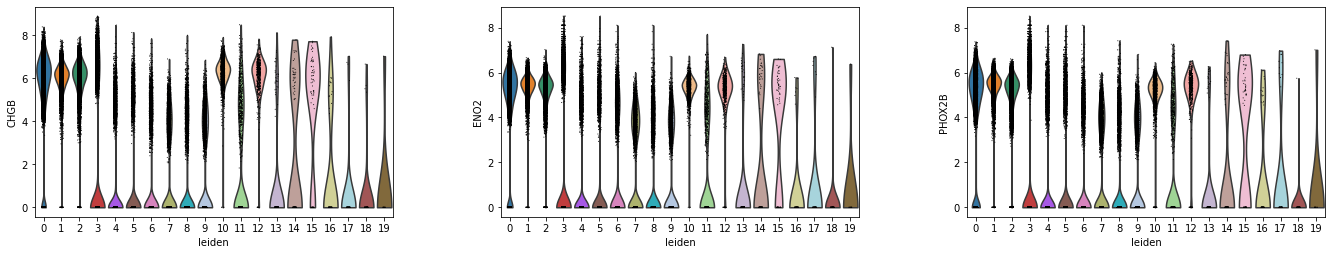

In [29]:
sc.pl.violin(adata, ['CHGB', 'ENO2', 'PHOX2B'], groupby='leiden')

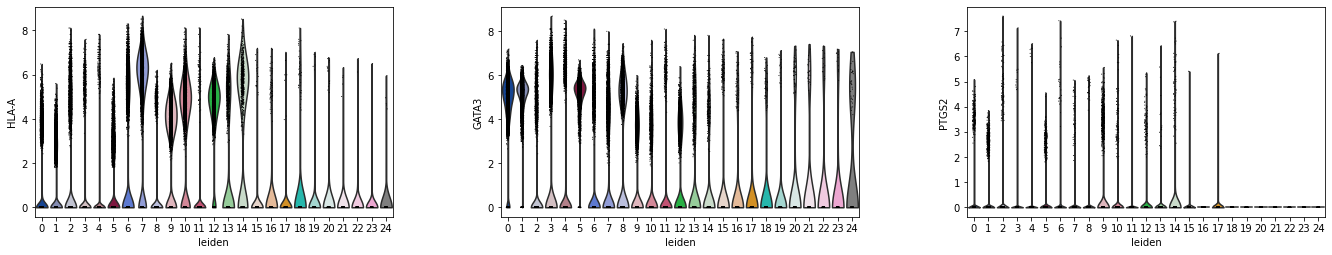

In [113]:
sc.pl.violin(adata, ['HLA-A', 'GATA3', 'PTGS2'], groupby='leiden')

In [16]:
list(filter(lambda x:'BMP' in x, adata.var_names))

['BMPR1B']

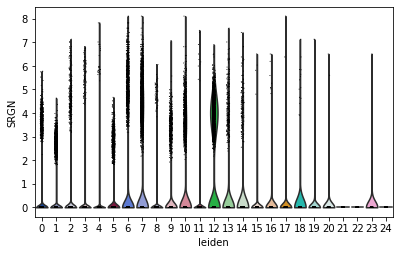

In [18]:
sc.pl.violin(adata, ['SRGN'], groupby='leiden')

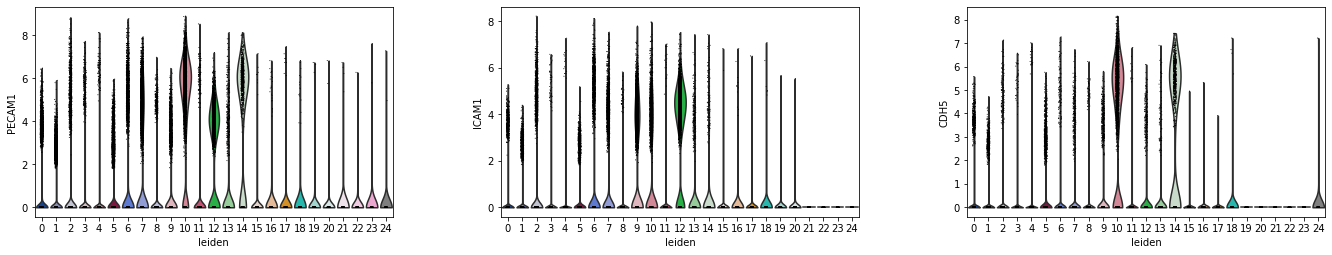

In [122]:
sc.pl.violin(adata, ['PECAM1', 'ICAM1', 'CDH5'], groupby='leiden')

## Adding annotations

Yasin annotated the clusters based on the top 10 cluster marker genes. Using that to call cell labels

In [2]:
adata = sc.read('baysor_seg.h5ad')
adata

AnnData object with n_obs × n_vars = 137694 × 398
    obs: 'cluster', 'x', 'y', 'global_x', 'global_y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
cluster = pd.read_excel('../Documents/Cluster_Markers.xlsx', index_col=0)
cluster.head()

0           1           2           3            4   \
Cluster                                                                
Rank     Adrenergic  Adrenergic  Fibroblast  Adrenergic  Adrn_Cortex   
0              CHGB        SYN3      COL1A1        TUBB      CYP11B2   
1              ENO2       GRIK2         VIM       H3-3B        MYOM1   
2             MAP1B       GATA3       THBS1        PRPH         CD3G   
3             L1CAM       ALCAM       EPAS1      PHOX2B        DPP10   

                 5               6       7           8           9   ...  \
Cluster                                                              ...   
Rank     Adrenergic  Macrophage_TAM  T_Cell  Adrenergic  Fibroblast  ...   
0             GATA3            CD74    CD3E        CHGB      COL1A1  ...   
1            PHOX2B            C1QC   HLA-A       L1CAM         VIM  ...   
2              ENO2         HLA-DRA   CD247       GRIK2       THBS1  ...   
3              RTN3           MPEG1   HLA-B         ALK         FN1  ...   

                            15      16          17       18          19  \
Cluster                                                                   
Rank     Adrenergic_or_Schwann    Treg  Adrenergic  NK_Cell  Adrenergic   
0                     ARHGAP36   PDCD1       IL2RA     CCR2      OSBPL3   
1                         SPP1   FOXP3       CD274    IGHG1        RGS5   
2                      PPP2R2C  COL1A1        ELL2     CD68     CYP11B2   
3                        UNC5D   EPAS1       NLGN1  CYP11B2     ADCYAP1   

             20     21       22              23      24  
Cluster                                                  
Rank     B_Cell    TAC      TAC  Macrophage_TRM  B_Cell  
0        PRSS12  NTRK2  GRAMD1B            LMNA    FHIT  
1         CREB5  CALCA   LRRTM4          SLC2A3   GRIK2  
2          NCR1  GULP1    NR4A3            PKIB   KCNH5  
3          SV2C   CD3G   IMMP2L            COBL  FRMD4B  

[5 rows x 25 columns]

In [4]:
cl_dict = dict(zip(cluster.columns, cluster.loc["Rank",:]))

In [5]:
adata.obs['cell_type'] = adata.obs['leiden'].apply(lambda x: cl_dict[int(x)])

/mnt/isilon/cscb/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


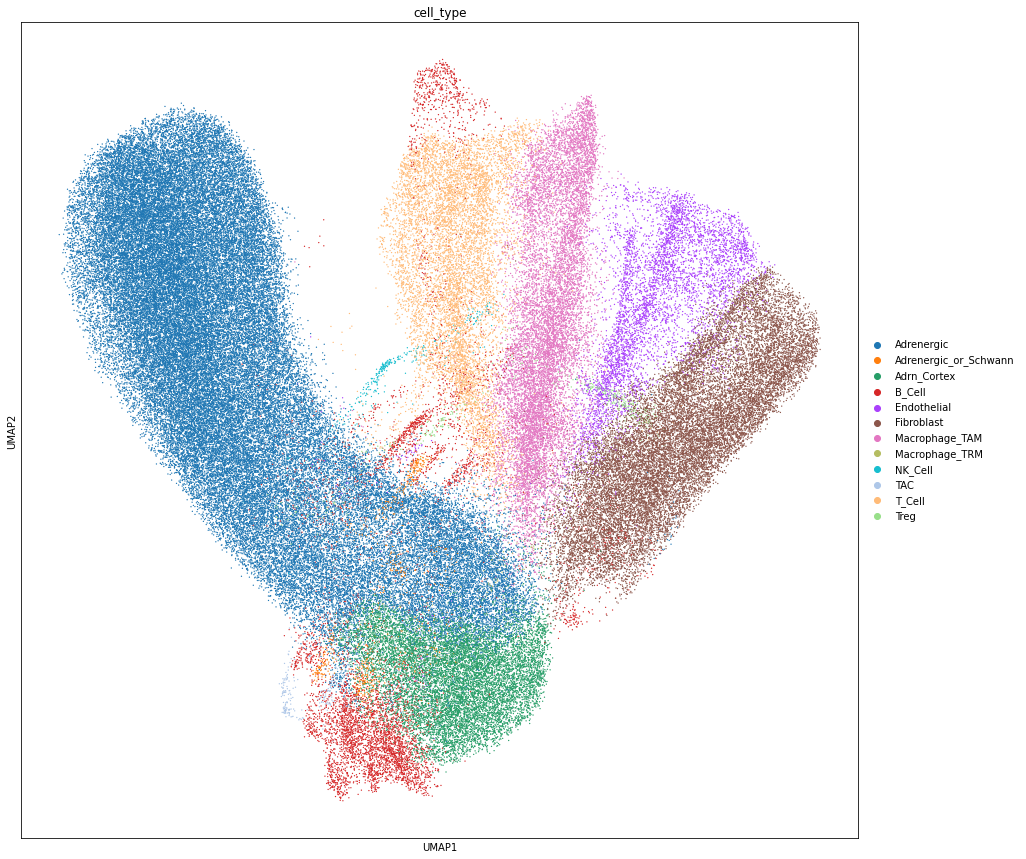

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata, color='cell_type', ax=ax, size=7)
fig.savefig('plots/UMAP_labels.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
with open('adata_m200_obs.pk', 'wb') as f:
    pk.dump(adata.obs, f)

In [28]:
adata.obs['x'].max()

107475.96995949162